In [1]:
from collections import Counter
import pickle
import os
import yaml
import random
import numpy as np
import pandas as pd

from time import time
import matplotlib.pyplot as plt

from scipy.stats import bernoulli, gaussian_kde
from sklearn import decomposition

#import bkcharts
#import bokeh.io
#import bokeh.palettes
#from bokeh.models import ColumnDataSource, LabelSet
#from bokeh.layouts import row
#from bokeh.plotting import figure
#bokeh.io.output_notebook()
#import holoviews as hv
#hv.notebook_extension('plotly')
import matplotlib.pyplot as plt

os.chdir(os.path.expanduser("~/projects/embedding/src"))
from probe2vec.w2v import word2vec, Word2VecEmbedder
from probe2vec.dataset_reader import DatasetReader
from probe2vec.embedding_utils import build_index, most_similar, merge_counters, reshape_to_vector, SequenceParser
from probe2vec.theano_minibatcher import (
    TheanoMinibatcher, NoiseContrastiveTheanoMinibatcher
)

In [2]:
# get the model file params
%matplotlib inline

config_dir = os.path.expanduser('~/projects/embedding/src/config_yamls/atac_kmer_models/')
results_dir = os.path.expanduser('~/projects/embedding/results/GM12878_atac/distal_seq_kernel/k_6_s_1')
model_yaml = 'k_6_s_1_distal.yaml'
with open(os.path.join(config_dir, model_yaml)) as f:
    params = yaml.load(f)

In [3]:
# load the embedder
ChIP_data_dir = os.path.expanduser('~/projects/SeqDemote/data/ChIP/GM12878/chip_fasta_files')
os.chdir(os.path.expanduser("~/projects/embedding/src"))

## Set up the machinery for reading, parsing, and embedding sequences

In [4]:
my_sp = SequenceParser(**params)

# load the DatasetReader object from the save dir
reader = DatasetReader(files=[], directories=[], skip=[], noise_ratio=15, 
                      t=1e-5, num_processes=3, 
                      unigram_dictionary=None, 
                      min_frequency=0, kernel=[1, 2, 3, 
                      4, 5, 5, 4, 3, 2, 1], 
                      load_dictionary_dir=params['save_dir'], 
                      max_queue_size=0, 
                      macrobatch_size=20000, 
                      parser=my_sp, 
                      verbose=True, k=params['K'], 
                      stride=params['stride'])
    
# load the embedder, DatasetReader objects
batch_size = 1000
noise_ratio=15
num_embedding_dimensions=params['num_embedding_dimensions']
full_batch_size = batch_size * (1 + noise_ratio)

minibatcher = NoiseContrastiveTheanoMinibatcher(
    batch_size=batch_size,
    noise_ratio=noise_ratio,
    dtype="int32",
    num_dims=2
)

embedder = Word2VecEmbedder(input_var=minibatcher.get_batch(),
                            batch_size=full_batch_size,
                            vocabulary_size=reader.get_vocab_size(),
                            num_embedding_dimensions=num_embedding_dimensions)
embedder.load(os.path.join(params['save_dir'],''))
params['save_dir']

Loading dictionary from ../results/GM12878_atac/distal_seq_kernel/k_6_s_1...
pruning dictionary to eliminate tokens occuring less than 0 times.
dropped  0  tokens in pruning the unigram dictionary


'../results/GM12878_atac/distal_seq_kernel/k_6_s_1'

In [5]:
# Load a random set of probes from a randomly chosen factor, embed, and visualize the probes
def sample_from_factor(filename, percentage=0.5):
    tokenized_sentences = my_sp.parse(filename) 
    samples = bernoulli.rvs(percentage,size=len(tokenized_sentences)).astype('bool').tolist()
    return [s for s,i in zip(tokenized_sentences,samples) if i], [s for s,i in zip(tokenized_sentences,samples) if not i]
    

# Sample a factor from the ChIP data
Here is the recipe for orthogonal validation of an embedding model via ChIP data:
- choose a factor
- sample sequences from the peaks
- sample sequences from the flanks
- transform sequences into embedding space to get the embedded features
- transform sequences via HashingVectorizer to get the direct from sequence features
- push both through a pipeline for classification of peaks from flanks

In [6]:
# choose the factor
factors = os.listdir(ChIP_data_dir)
random.shuffle(factors)
factor = factors[0]
peaks_files = [f for f in os.listdir(os.path.join(ChIP_data_dir,factor)) if f.endswith("peaks.fa")]
peak_file = os.path.join(ChIP_data_dir,factor,peaks_files[0])
flank_files = [f for f in os.listdir(os.path.join(ChIP_data_dir,factor)) if f.endswith("flanks.fa")]
flank_file = os.path.join(ChIP_data_dir,factor,flank_files[0])

# sample peak, flank sequences
percentage = 0.8
training_peaks, validation_peaks = sample_from_factor(peak_file, percentage)
training_flanks, validation_flanks = sample_from_factor(flank_file, percentage)

print("Number of training peaks: ", len(training_peaks))
print("Number of validation peaks: ", len(validation_peaks))
print("Number of training flanks: ", len(training_flanks))
print("Number of validation flanks: ", len(validation_flanks))

Number of training peaks:  3145
Number of validation peaks:  821
Number of training flanks:  6308
Number of validation flanks:  1620


### Package up the data set
1. Embed the peaks, flanks into the embedding space
2. Form the peaks, flanks into a numpy array, and make the labels

In [7]:
# Embed each of the k-mers from the sample sentences, and the other sentences
embedded_peaks = []
embedded_peaks_means = []
for count, peak in enumerate(training_peaks):
    peak_token_ids = [reader.unigram_dictionary.get_id(token) for token in peak]
    embedded_tokens = [embedder.embed(t) for t in peak_token_ids]
    embedded_peaks.append(embedded_tokens)
    embedded_peaks_means.append(np.concatenate(embedded_tokens).mean(axis=0))
 
training_peak_X = np.stack(embedded_peaks_means)

embedded_flanks = []
embedded_flanks_means = []
for count, flank in enumerate(training_flanks):
    flank_token_ids = [reader.unigram_dictionary.get_id(token) for token in flank]
    embedded_tokens = [embedder.embed(t) for t in flank_token_ids]
    embedded_flanks.append(embedded_tokens)
    embedded_flanks_means.append(np.concatenate(embedded_tokens).mean(axis=0))
   
training_flank_X = np.stack(embedded_flanks_means)

training_peak_labels = np.ones((len(training_peaks),))
training_flank_labels = np.zeros((len(training_flanks),))
print("training peaks shape: ", training_peak_X.shape)
print("training flanks shape:", training_flank_X.shape)

X_train_embedded = np.concatenate((training_peak_X,training_flank_X))
Y_train_labels = np.concatenate((training_peak_labels,training_flank_labels))

print("Shape of the training data: ", X_train_embedded.shape)
print("Shape of the training labels: ", Y_train_labels.shape)

training peaks shape:  (3145, 100)
training flanks shape: (6308, 100)
Shape of the training data:  (9453, 100)
Shape of the training labels:  (9453,)


### Encode the validation data similarly

In [8]:
# Embed each of the k-mers from the sample sentences, and the other sentences
embedded_peaks = []
embedded_peaks_means = []
for count, peak in enumerate(validation_peaks):
    peak_token_ids = [reader.unigram_dictionary.get_id(token) for token in peak]
    embedded_tokens = [embedder.embed(t) for t in peak_token_ids]
    embedded_peaks.append(embedded_tokens)
    embedded_peaks_means.append(np.concatenate(embedded_tokens).mean(axis=0))
 
validation_peak_X = np.stack(embedded_peaks_means)

embedded_flanks = []
embedded_flanks_means = []
for count, flank in enumerate(validation_flanks):
    flank_token_ids = [reader.unigram_dictionary.get_id(token) for token in flank]
    embedded_tokens = [embedder.embed(t) for t in flank_token_ids]
    embedded_flanks.append(embedded_tokens)
    embedded_flanks_means.append(np.concatenate(embedded_tokens).mean(axis=0))
   
validation_flank_X = np.stack(embedded_flanks_means)

validation_peak_labels = np.ones((len(validation_peaks),))
validation_flank_labels = np.zeros((len(validation_flanks),))
print("Validation peak shape: ", validation_peak_X.shape)
print("Validation flank shape:", validation_flank_X.shape)

X_validation_embedded = np.concatenate((validation_peak_X, validation_flank_X))
Y_validation_labels = np.concatenate((validation_peak_labels, validation_flank_labels))

print("Shape of the validation data: ", X_validation_embedded.shape)
print("Shape of the validation labels: ", Y_validation_labels.shape)

Validation peak shape:  (821, 100)
Validation flank shape: (1620, 100)
Shape of the validation data:  (2441, 100)
Shape of the validation labels:  (2441,)


### Transform the peaks, flanks via CountVectorizer and Random Projection

As a comparison to the w2v embedding, use the CountVectorizer to turn each probe into a vector of counts, then project that vector of counts down to a 100 dimensional space via Random Projections.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import vstack
vectorizer = CountVectorizer(analyzer='word',lowercase=False)

joint_corpus = [" ".join(p) for p in training_peaks]
for l in [[" ".join(f) for f in training_flanks], [" ".join(p) for p in validation_peaks], [" ".join(p) for p in validation_flanks]]:
    joint_corpus.extend(l)
vectorizer.fit(joint_corpus)

train_peaks_counts = vectorizer.transform([" ".join(p) for p in training_peaks])
train_flanks_counts = vectorizer.transform([" ".join(f) for f in training_flanks])
valid_peaks_counts = vectorizer.transform([" ".join(p) for p in validation_peaks])
valid_flanks_counts = vectorizer.transform([" ".join(p) for p in validation_flanks])


In [14]:
from sklearn.random_projection import GaussianRandomProjection

gpr = GaussianRandomProjection(n_components=100)
gpr.fit(train_peaks_counts)

train_peaks_vectorized = gpr.transform(train_peaks_counts)
train_flanks_vectorized = gpr.transform(train_flanks_counts)
valid_peaks_vectorized = gpr.transform(valid_peaks_counts)
valid_flanks_vectorized = gpr.transform(valid_flanks_counts)

print("Shape, type of train_peaks_vectorized: ", train_peaks_vectorized.shape, type(train_peaks_vectorized))
print("Shape, type of train_flanks_vectorized: ", train_flanks_vectorized.shape, type(train_flanks_vectorized))

X_train_hashed = vstack((train_peaks_vectorized, train_flanks_vectorized))
X_valid_hashed = vstack((valid_peaks_vectorized, valid_flanks_vectorized))

print("Shape of the RP k-mer training data: ", X_train_hashed.shape)
print("Shape of the RP k-mer validation data: ", X_valid_hashed.shape)

Shape, type of train_peaks_vectorized:  (3145, 100) <class 'numpy.ndarray'>
Shape, type of train_flanks_vectorized:  (6308, 100) <class 'numpy.ndarray'>
Shape of the RP k-mer training data:  (9453, 100)
Shape of the RP k-mer validation data:  (2441, 100)


### Train competing classifiers on each feature set, evaluate on validation set

In [15]:
from sklearn import metrics

def benchmark(clf, train_data, train_labels, valid_data, valid_labels, print_report=True, print_cm=True):
    
    clf.fit(train_data, train_labels)
    pred = clf.predict(valid_data)
    
    if hasattr(clf, 'decision_function'):
        pred_score = clf.decision_function(valid_data)
        
    elif hasattr(clf, 'predict_proba'):
        pred_score = clf.predict_proba(valid_data)[:, 1]
        
    aupr = metrics.average_precision_score(valid_labels, pred_score)
    auroc = metrics.roc_auc_score(valid_labels, pred_score)    
    score = metrics.accuracy_score(valid_labels, pred) 
    f_one = metrics.f1_score(valid_labels, pred)
    
    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

    if print_report:
        print("classification report:")
        print(metrics.classification_report(valid_labels, pred))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(valid_labels, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    
    return clf_descr, score, aupr, auroc, f_one
    



In [16]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn.feature_selection import SelectFromModel

embedded_results, hashed_results = [], []

for train_data, valid_data, results in [[X_train_embedded, X_validation_embedded, embedded_results],
                                        [X_train_hashed, X_valid_hashed, hashed_results]]:
    for clf, name in (
            (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
            (KNeighborsClassifier(n_neighbors=10), "kNN"),
            (RandomForestClassifier(n_estimators=100), "Random forest")):
        print('=' * 80)
        print(name)
        results.append(benchmark(clf, train_data, Y_train_labels, valid_data, Y_validation_labels))

    for penalty in ["l2", "l1"]:
        print('=' * 80)
        print("%s penalty" % penalty.upper())
        # Train Liblinear model
        results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                           tol=1e-3),
                                 train_data, Y_train_labels, valid_data, Y_validation_labels))

        # Train SGD model
        results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                               penalty=penalty),
                                train_data, Y_train_labels, valid_data, Y_validation_labels))

    # Train SGD with Elastic Net penalty
    print('=' * 80)
    print("Elastic-Net penalty")
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty="elasticnet"),
                            train_data, Y_train_labels, valid_data, Y_validation_labels))

    # Train sparse Naive Bayes classifiers
    print('=' * 80)
    print("Naive Bayes")
    results.append(benchmark(BernoulliNB(alpha=.01),
                  train_data, Y_train_labels, valid_data, Y_validation_labels))

    print('=' * 80)
    print("LinearSVC with L1-based feature selection")
    # The smaller C, the stronger the regularization.
    # The more regularization, the more sparsity.
    results.append(benchmark(Pipeline([
      ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                      tol=1e-3))),
      ('classification', LinearSVC(penalty="l2"))]),
                  train_data, Y_train_labels, valid_data, Y_validation_labels))

Ridge Classifier
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.77      0.90      0.83      1620
        1.0       0.70      0.45      0.55       821

avg / total       0.74      0.75      0.74      2441

confusion matrix:
[[1462  158]
 [ 448  373]]

kNN
classification report:
             precision    recall  f1-score   support

        0.0       0.73      0.89      0.80      1620
        1.0       0.62      0.37      0.46       821

avg / total       0.69      0.71      0.69      2441

confusion matrix:
[[1434  186]
 [ 521  300]]

Random forest
classification report:
             precision    recall  f1-score   support

        0.0       0.73      0.92      0.82      1620
        1.0       0.68      0.33      0.45       821

avg / total       0.71      0.72      0.69      2441

confusion matrix:
[[1492  128]
 [ 548  273]]

L2 penalty
dimensionality: 100
density: 1.000000
classification report:
   

/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.76      0.91      0.83      1620
        1.0       0.71      0.43      0.53       821

avg / total       0.74      0.75      0.73      2441

confusion matrix:
[[1480  140]
 [ 472  349]]

L1 penalty
dimensionality: 100
density: 0.700000
classification report:
             precision    recall  f1-score   support

        0.0       0.77      0.89      0.83      1620
        1.0       0.69      0.48      0.57       821

avg / total       0.74      0.75      0.74      2441

confusion matrix:
[[1443  177]
 [ 428  393]]



/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.700000
classification report:
             precision    recall  f1-score   support

        0.0       0.81      0.83      0.82      1620
        1.0       0.64      0.61      0.63       821

avg / total       0.75      0.75      0.75      2441

confusion matrix:
[[1341  279]
 [ 321  500]]

Elastic-Net penalty


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.910000
classification report:
             precision    recall  f1-score   support

        0.0       0.76      0.90      0.83      1620
        1.0       0.70      0.45      0.55       821

avg / total       0.74      0.75      0.73      2441

confusion matrix:
[[1465  155]
 [ 455  366]]

Naive Bayes
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.78      0.57      0.66      1620
        1.0       0.44      0.68      0.54       821

avg / total       0.67      0.61      0.62      2441

confusion matrix:
[[925 695]
 [264 557]]

LinearSVC with L1-based feature selection
classification report:
             precision    recall  f1-score   support

        0.0       0.77      0.89      0.83      1620
        1.0       0.70      0.48      0.57       821

avg / total       0.75      0.75      0.74      2441

confusion matrix:
[[1448  172]
 [ 429  392]]

Ridge Classifier


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:319: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.69      0.91      0.78      1620
        1.0       0.51      0.18      0.26       821

avg / total       0.63      0.67      0.61      2441

confusion matrix:
[[1481  139]
 [ 675  146]]

kNN
classification report:
             precision    recall  f1-score   support

        0.0       0.68      0.88      0.77      1620
        1.0       0.42      0.17      0.24       821

avg / total       0.59      0.64      0.59      2441

confusion matrix:
[[1427  193]
 [ 683  138]]

Random forest
classification report:
             precision    recall  f1-score   support

        0.0       0.67      0.99      0.79      1620
        1.0       0.47      0.03      0.05       821

avg / total       0.60      0.66      0.54      2441

confusion matrix:
[[1596   24]
 [ 800   21]]

L2 penalty
dimensionality: 100
density: 1.000000
classification report:
             precisi

/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.67      0.83      0.74      1620
        1.0       0.37      0.20      0.26       821

avg / total       0.57      0.62      0.58      2441

confusion matrix:
[[1339  281]
 [ 657  164]]

L1 penalty
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.68      0.92      0.78      1620
        1.0       0.51      0.17      0.25       821

avg / total       0.63      0.67      0.61      2441

confusion matrix:
[[1487  133]
 [ 684  137]]



/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.290000
classification report:
             precision    recall  f1-score   support

        0.0       0.70      0.66      0.68      1620
        1.0       0.40      0.45      0.42       821

avg / total       0.60      0.59      0.59      2441

confusion matrix:
[[1072  548]
 [ 455  366]]

Elastic-Net penalty


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.400000
classification report:
             precision    recall  f1-score   support

        0.0       0.69      0.84      0.76      1620
        1.0       0.45      0.26      0.33       821

avg / total       0.61      0.65      0.61      2441

confusion matrix:
[[1365  255]
 [ 611  210]]

Naive Bayes
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.69      0.84      0.76      1620
        1.0       0.45      0.26      0.33       821

avg / total       0.61      0.64      0.61      2441

confusion matrix:
[[1360  260]
 [ 608  213]]

LinearSVC with L1-based feature selection
classification report:
             precision    recall  f1-score   support

        0.0       0.68      0.89      0.77      1620
        1.0       0.46      0.18      0.26       821

avg / total       0.61      0.65      0.60      2441

confusion matrix:
[[1447  173]
 [ 671  150]]



### Pack results into a df for plotting:
Results lists consist of: score, aupr, auroc, f_one
Need to tidy up data, get a df with cols identifying:
- classifier
- feature set
- measure

In [17]:
import pandas as pd

def assemble_df(results_list, factor, features):
    ''' turn results list into dict for df transformation '''
    
    entries = len(results_list)
    pd_dict = {'Features': [features for f in range(entries)], 'Classifier': [], 'Accuracy': [], 'AUROC': [], 'AUPR': [], 'F1': []}
    for record in results_list:
        name, acc, aupr, auroc, f_one = record
        pd_dict['Classifier'].append(name)
        pd_dict['Accuracy'].append(acc)
        pd_dict['AUPR'].append(aupr)
        pd_dict['AUROC'].append(auroc)
        pd_dict['F1'].append(f_one)
        
    return pd.DataFrame.from_dict(pd_dict)

In [18]:
# embedded_results, hashed_results
embedded_features_df = assemble_df(embedded_results, factor, "Embedding features")
hashed_features_df = assemble_df(hashed_results, factor, "Random Projection features")

# concat dfs
all_features_df = pd.concat([embedded_features_df, hashed_features_df])

# melt into tidy format
tidy_df = pd.melt(all_features_df, id_vars=['Classifier', 'Features'], value_vars=['AUPR','AUROC','Accuracy','F1'], var_name='Metric', value_name='Value')

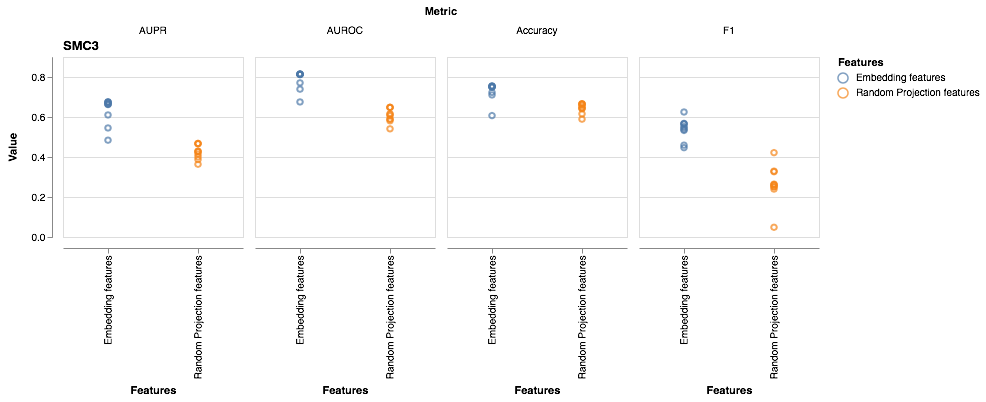

In [19]:
import altair as alt

title = factor

alt.Chart(tidy_df).mark_point().encode(
    x='Features:N',
    y='Value:Q',
    color='Features:N',
    column='Metric:N'
).properties(
    width=180,
    height=180,
    title=title
)